# Chapter 5 Value of Plays Using Run Expectancy

In [1]:
library(tidyverse)
library(Lahman)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
fields <- read_csv('datasets/fields.csv')
data_2011 <- read_csv('datasets/all2011.csv',col_names=pull(fields,Header),
                      na = character())



Rows: 97 Columns: 3
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Description, Header
dbl (1): Field number

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 191864 Columns: 97
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (34): GAME_ID, AWAY_TEAM_ID, PITCH_SEQ_TX, BAT_ID, BAT_HAND_CD, RESP_BAT...
dbl (35): INN_CT, BAT_HOME_ID, OUTS_CT, BALLS_CT, STRIKES_CT, AWAY_SCORE_CT,...
lgl (28): LEADOFF_FL, PH_FL, BAT_EVENT_FL, AB_FL, SH_FL, SF_

In [5]:
data_2011 %>%
mutate(RUNS = AWAY_SCORE_CT + HOME_SCORE_CT,
       HALF.INNING = paste(GAME_ID, INN_CT, BAT_HOME_ID),
        RUNS.SCORED =
         (BAT_DEST_ID> 3) + (RUN1_DEST_ID > 3)+
           (RUN2_DEST_ID>3) + (RUN3_DEST_ID> 3)) -> data_2011



## Now we want to compute the maximum total score for each half inning combining home and visitor scores

In [7]:
data_2011 %>%
    group_by(HALF.INNING) %>%
    summarize(Outs.Inning = sum(EVENT_OUTS_CT),
              Runs.Inning = sum(RUNS.SCORED),
                Runs.Start = first(RUNS),
                MAX.Runs = Runs.Inning + Runs.Start ) -> half_innings  
           

In [8]:
head(half_innings,10)

HALF.INNING,Outs.Inning,Runs.Inning,Runs.Start,MAX.Runs
<chr>,<dbl>,<int>,<dbl>,<dbl>
ANA201104080 1 0,3,0,0,0
ANA201104080 1 1,3,1,0,1
ANA201104080 2 0,3,0,1,1
ANA201104080 2 1,3,0,1,1
ANA201104080 3 0,3,0,1,1
ANA201104080 3 1,3,1,1,2
ANA201104080 4 0,3,0,2,2
ANA201104080 4 1,3,0,2,2
ANA201104080 5 0,3,0,2,2


In [10]:
data_2011 %>%
    inner_join(half_innings, by = "HALF.INNING") %>%
    mutate(RUNS.ROI = MAX.Runs - RUNS) -> data_2011

## Creating the Matrix

In [12]:
data_2011 %>%
mutate(BASES = paste(
  ifelse(BASE1_RUN_ID> "", 1,0),
  ifelse(BASE2_RUN_ID> "", 1,0),
  ifelse(BASE3_RUN_ID> "", 1,0), sep=""
  ), 
   STATE = paste(BASES, OUTS_CT)) -> data_2011

### We only want to consider plays in df where there is some form of change  in the runners on base, number of outs, or runs scored

In [15]:
# the nrunner variables confirm if after the play those bags are occupied or not
#NOUTS IS NUM OF OUTS AFTER THE PLAY
data_2011 %>%
mutate(NRUNNER1 = as.numeric(RUN1_DEST_ID == 1 | BAT_DEST_ID == 1),
       NRUNNER2 = as.numeric(RUN1_DEST_ID == 2 | RUN2_DEST_ID == 2 | BAT_DEST_ID == 2),
        NRUNNER3 = as.numeric(RUN1_DEST_ID == 3 | RUN2_DEST_ID == 3 | RUN3_DEST_ID == 3 | BAT_DEST_ID == 3),
        NOUTS = OUTS_CT + EVENT_OUTS_CT ,
        NEW.BASES = paste(NRUNNER1,NRUNNER2,NRUNNER3,sep=""),
        NEW.STATE = paste(NEW.BASES, NOUTS)) -> data_2011

In [16]:
# now use filter to restrict our attention to plays that either there is a change between state and new.state

data_2011 %>%
  filter((STATE != NEW.STATE ) | (RUNS.SCORED> 0)) -> data_2011

## Before run expectancy is computed we only want complete full half innings (some innings end early because of things such as walkoffs for example

In [17]:
data_2011 %>%
filter(Outs.Inning == 3) -> data_2011C

## We compute the expected number of runs scored in remainder of inning for each 24 base out situation 

In [20]:
data_2011C %>%
    group_by(STATE) %>%
    summarize(Mean = mean(RUNS.ROI)) %>%
    mutate(Outs = substr(STATE,5,5)) %>%
    arrange(Outs) -> RUNS


head(RUNS,10)

STATE,Mean,Outs
<chr>,<dbl>,<chr>
000 0,0.4711649,0
001 0,1.4543568,0
010 0,1.0582804,0
011 0,1.9304897,0
100 0,0.8350992,0
101 0,1.7526998,0
110 0,1.4144549,0
111 0,2.1718266,0
000 1,0.2546956,1


In [22]:
RUNS_outs <- matrix(round(RUNS$Mean,2), 8, 3)
dimnames(RUNS_outs)[[2]] <- c("0 outs", "1 out", "2 outs")
dimnames(RUNS_outs)[[1]] <- c("000", "001", "010", "011",
                               "100", "101", "110", "111")  

RUNS_outs

,0 outs,1 out,2 outs
000,0.47,0.25,0.10
001,1.45,0.94,0.32
010,1.06,0.65,0.31
011,1.93,1.34,0.54
100,0.84,0.50,0.22
101,1.75,1.15,0.49
110,1.41,0.87,0.42
111,2.17,1.47,0.76


## Run Expectancy Matrix

# Measuring Success of a Batting Play

### We estimate the value of the plate appearance called the run value by computing the difference in run expectancies of the old and new states plus the number of runs scored on the particular play

#### RUN VALUE = RUNS(new state) - RUNS(Old State) + RUNS(Scored on the play)

In [24]:
data_2011 %>%
    left_join(select(RUNS, -Outs), by="STATE") %>%
    rename(Runs.State = Mean) %>%
    left_join(select(RUNS, -Outs),
              by= c("NEW.STATE" = "STATE")) %>%
    rename(Runs.New.State = Mean) %>%
    replace_na(list(Runs.New.State = 0)) %>%
    mutate(run_value = Runs.New.State - Runs.State + RUNS.SCORED) -> data_2011
    

## Josh Hamilton

In [49]:
People %>%
  filter(nameFirst == "Josh" & nameLast == "Hamilton") %>%
  pull(retroID) -> josh_hamilton_ID


josh_hamilton_ID

[1] "hamij003"

In [54]:
# batting_fl is a batting flag variable so it does for if he is the batter
data_2011 %>%
  filter(BAT_ID == josh_hamilton_ID, BAT_EVENT_FL == TRUE) -> josh_hamilton_at_bats

colnames(josh_hamilton_at_bats)

[1] "GAME_ID"                   "AWAY_TEAM_ID"             
  [3] "INN_CT"                    "BAT_HOME_ID"              
  [5] "OUTS_CT"                   "BALLS_CT"                 
  [7] "STRIKES_CT"                "PITCH_SEQ_TX"             
  [9] "AWAY_SCORE_CT"             "HOME_SCORE_CT"            
 [11] "BAT_ID"                    "BAT_HAND_CD"              
 [13] "RESP_BAT_ID"               "RESP_BAT_HAND_CD"         
 [15] "PIT_ID"                    "PIT_HAND_CD"              
 [17] "RESP_PIT_ID"               "RESP_PIT_HAND_CD"         
 [19] "POS2_FLD_ID"               "POS3_FLD_ID"              
 [21] "POS4_FLD_ID"               "POS5_FLD_ID"              
 [23] "POS6_FLD_ID"               "POS7_FLD_ID"              
 [25] "POS8_FLD_ID"               "POS9_FLD_ID"              
 [27] "BASE1_RUN_ID"              "BASE2_RUN_ID"             
 [29] "BASE3_RUN_ID"              "EVENT_TX"                 
 [31] "LEADOFF_FL"                "PH_FL"                    
 [33] "BAT_FLD_CD"                "BAT_LINEUP_ID"            
 [35] "EVENT_CD"                  "BAT_EVENT_FL"             
 [37] "AB_FL"                     "H_FL"                     
 [39] "SH_FL"                     "SF_FL"                    
 [41] "EVENT_OUTS_CT"             "DP_FL"                    
 [43] "TP_FL"                     "RBI_CT"                   
 [45] "WP_FL"                     "PB_FL"                    
 [47] "FLD_CD"                    "BATTEDBALL_CD"            
 [49] "BUNT_FL"                   "FOUL_FL"                  
 [51] "BATTEDBALL_LOC_TX"         "ERR_CT"                   
 [53] "ERR1_FLD_CD"               "ERR1_CD"                  
 [55] "ERR2_FLD_CD"               "ERR2_CD"                  
 [57] "ERR3_FLD_CD"               "ERR3_CD"                  
 [59] "BAT_DEST_ID"               "RUN1_DEST_ID"             
 [61] "RUN2_DEST_ID"              "RUN3_DEST_ID"             
 [63] "BAT_PLAY_TX"               "RUN1_PLAY_TX"             
 [65] "RUN2_PLAY_TX"              "RUN3_PLAY_TX"             
 [67] "RUN1_SB_FL"                "RUN2_SB_FL"               
 [69] "RUN3_SB_FL"                "RUN1_CS_FL"               
 [71] "RUN2_CS_FL"                "RUN3_CS_FL"               
 [73] "RUN1_PK_FL"                "RUN2_PK_FL"               
 [75] "RUN3_PK_FL"                "RUN1_RESP_PIT_ID"         
 [77] "RUN2_RESP_PIT_ID"          "RUN3_RESP_PIT_ID"         
 [79] "GAME_NEW_FL"               "GAME_END_FL"              
 [81] "PR_RUN1_FL"                "PR_RUN2_FL"               
 [83] "PR_RUN3_FL"                "REMOVED_FOR_PR_RUN1_ID"   
 [85] "REMOVED_FOR_PR_RUN2_ID"    "REMOVED_FOR_PR_RUN3_ID"   
 [87] "REMOVED_FOR_PH_BAT_ID"     "REMOVED_FOR_PH_BAT_FLD_CD"
 [89] "PO1_FLD_CD"                "PO2_FLD_CD"               
 [91] "PO3_FLD_CD"                "ASS1_FLD_CD"              
 [93] "ASS2_FLD_CD"               "ASS3_FLD_CD"              
 [95] "ASS4_FLD_CD"               "ASS5_FLD_CD"              
 [97] "EVENT_ID"                  "RUNS"                     
 [99] "HALF.INNING"               "RUNS.SCORED"              
[101] "Outs.Inning"               "Runs.Inning"              
[103] "Runs.Start"                "MAX.Runs"                 
[105] "RUNS.ROI"                  "BASES"                    
[107] "STATE"                     "NRUNNER1"                 
[109] "NRUNNER2"                  "NRUNNER3"                 
[111] "NOUTS"                     "NEW.BASES"                
[113] "NEW.STATE"                 "Runs.State"               
[115] "Runs.New.State"            "run_value"

## How did Josh Hamilton do in his first 10 plate appearances in 2011?

In [55]:
josh_hamilton_at_bats %>%
  select(GAME_ID,STATE, NEW.STATE, run_value) %>%
  slice(1:3)

GAME_ID,STATE,NEW.STATE,run_value
<chr>,<chr>,<chr>,<dbl>
ANA201107190,000 2,010 2,0.2119828
ANA201107190,010 0,001 1,-0.1208445
ANA201107190,100 0,110 0,0.5793557


In [56]:
josh_hamilton_at_bats %>%
  group_by(BASES) %>%
summarize(Number_Of_opportunites = n()) -> josh_ham_opportunites

josh_ham_opportunites

BASES,Number_Of_opportunites
<chr>,<int>
000,281
001,31
010,60
011,21
100,99
101,10
110,23
111,13


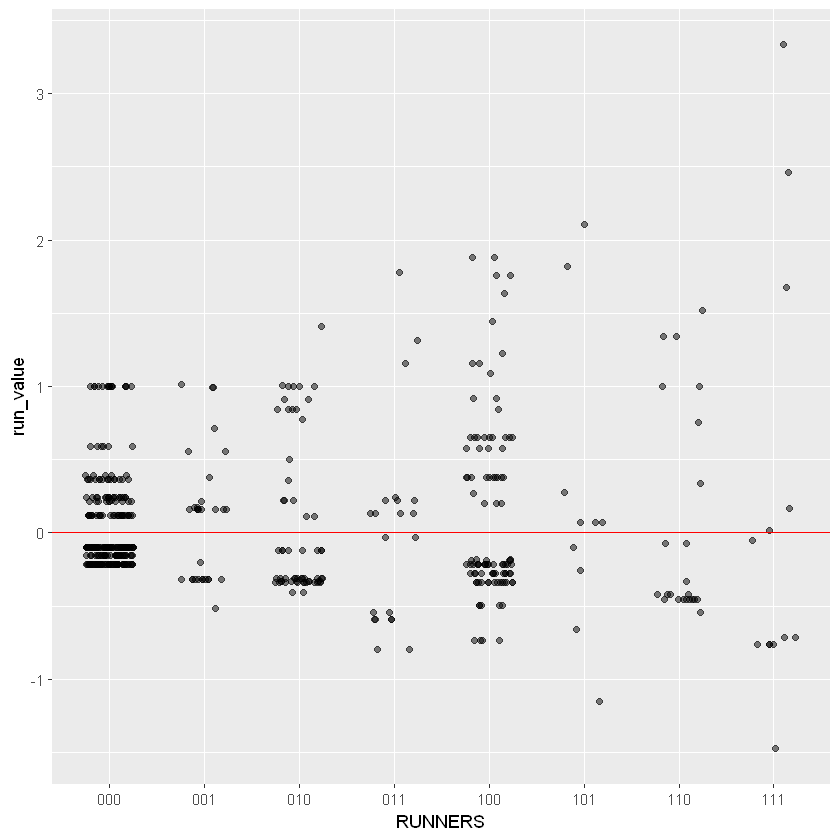

In [58]:
ggplot(josh_hamilton_at_bats, aes(BASES, run_value)) +
geom_jitter(width = .25, alpha = .5) + 
geom_hline(yintercept = 0, color='red')+
xlab("RUNNERS")

In [59]:
josh_runs <- josh_hamilton_at_bats %>%
              group_by(BASES) %>%
              summarize(
                      RUNS = sum(run_value),
                      Number_Of_Opportunites = n()
              )
josh_runs

BASES,RUNS,Number_Of_Opportunites
<chr>,<dbl>,<int>
000,9.7878794,281
001,2.8351110,31
010,2.5861556,60
011,0.5862898,21
100,11.9029191,99
101,2.2336190,10
110,0.9614396,23
111,1.6571612,13
